In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import torch as tc
%matplotlib inline

In [2]:
def gitit(commit_message):
    !git add micrograd.ipynb
    !git commit -m "{commit_message}"
    !git pull origin main --rebase
    !git push -u origin main

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

In [6]:
xs = np.arange(-5, 5.25, 0.25)
ys = f(xs)

In [7]:
display(xs)
ys

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75,  5.  ])

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875,  60.    ])

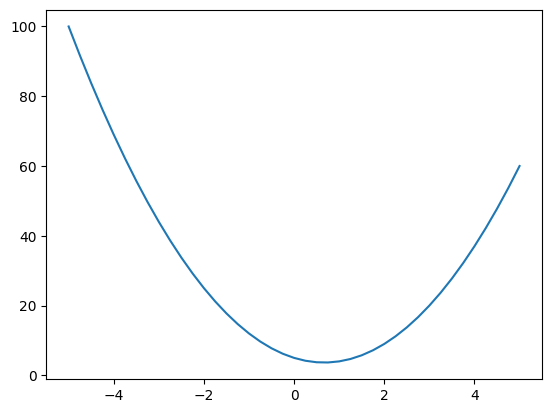

In [8]:
plt.plot(xs, ys)

In [9]:
h = 0.00000001
x = 3.0
(f(x + h) - f(x))/h

14.00000009255109

In [10]:
# more complex
a = 2.0
b = -3.0
c = 10
d = a*b + c
d

4.0

In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope of d with respect to a: ', (d2 - d1)/h)

d1:  4.0
d2:  3.999699999999999
slope of d with respect to a:  -3.000000000010772


In [12]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope of d with respect to b: ', (d2 - d1)/h)

d1:  4.0
d2:  4.0002
slope of d with respect to b:  2.0000000000042206


In [14]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope of  with respect to c: ', (d2 - d1)/h)

d1:  4.0
d2:  4.0001
slope of  with respect to c:  0.9999999999976694


In [79]:
class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out

    def radd(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
      
        return out
  
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
  
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
  
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
  
  
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [80]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
e = a * b
e.label = 'e'
c = Value(10.0, label='c')
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value(data=-8.0)

In [72]:
def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    from graphviz import Digraph

    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

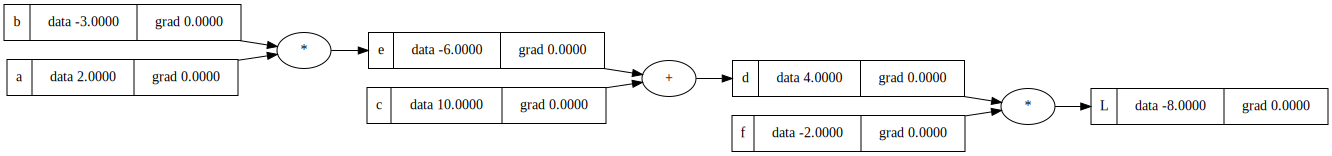

In [18]:
draw_dot(L)

In [19]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = f * d

L.data


-8.0

In [21]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a * b
    e.label = 'e'
    c = Value(10.0, label='c')
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    e = a * b
    e.label = 'e'
    c = Value(10.0, label='c')
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data + h

    print((L2 - L1) / h)

lol()

1.000000000000334


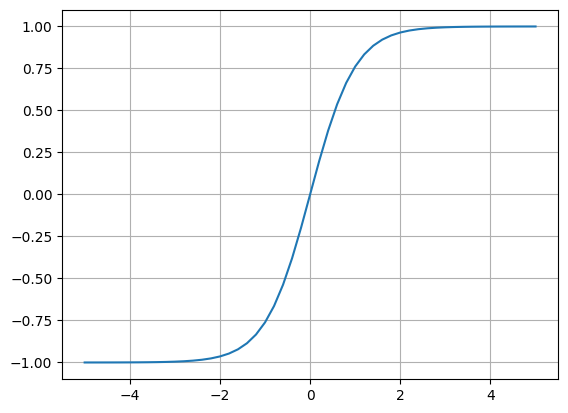

In [22]:
plt.plot(np.arange(-5,5.2,0.2), np.tanh(np.arange(-5,5.2,0.2)))
plt.grid()

In [23]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# steps
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

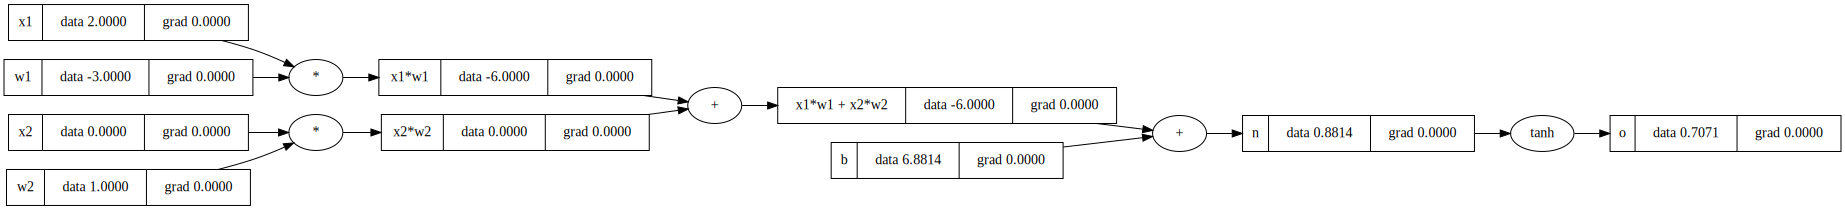

In [24]:
draw_dot(o)

In [25]:
o.grad = 1.0

In [26]:
n.grad = 1 - o.data**2

In [27]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [28]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [29]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

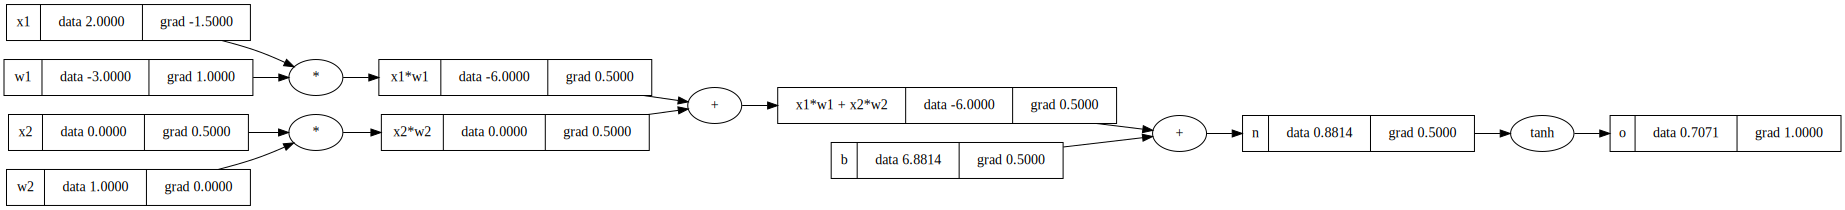

In [30]:
draw_dot(o)

In [31]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# steps
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backward()

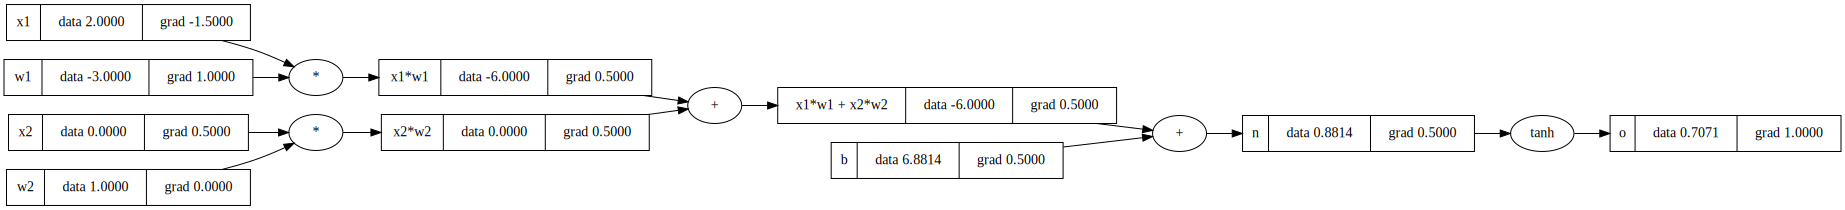

In [32]:
draw_dot(o)

In [35]:
o.grad = 1.0
o._backward()

n._backward()

b._backward()
x1w1x2w2._backward()

x1w1._backward()
x2w2._backward()

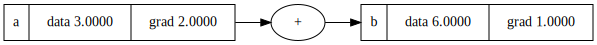

In [36]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)

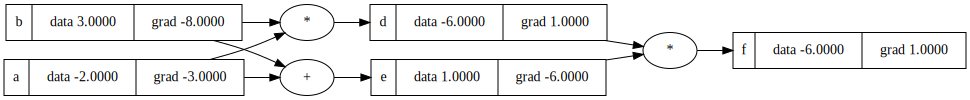

In [37]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a + b
e.label = 'e'
f = d * e
f.label = 'f'

f.backward()

draw_dot(f)

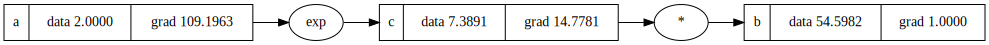

In [38]:
a = Value(2.0, label='a')
c = a.exp()
c.label = 'c'
b = c * c
b.label = 'b'

b.backward()

draw_dot(b)

In [39]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# steps
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
e = (2 * n).exp()
e.label = 'e'
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()

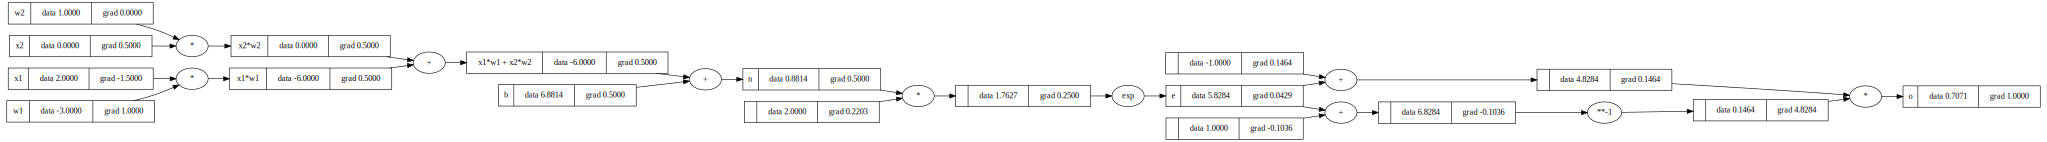

In [40]:
draw_dot(o)

In [41]:
x1 = tc.tensor([2.0], dtype=tc.float64, requires_grad=True)
w1 = tc.tensor([-3.0], dtype=tc.float64, requires_grad=True)
x2 = tc.tensor([0.0], dtype=tc.float64, requires_grad=True)
w2 = tc.tensor([1.0], dtype=tc.float64, requires_grad=True)
b = tc.tensor([6.8813735870195432], dtype=tc.float64, requires_grad=True)

n = x1 * w1 + x2 * w2 + b
o = tc.tanh(n)

o.backward()

In [51]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [81]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8850656948637501)

In [82]:
len(n.parameters())

41

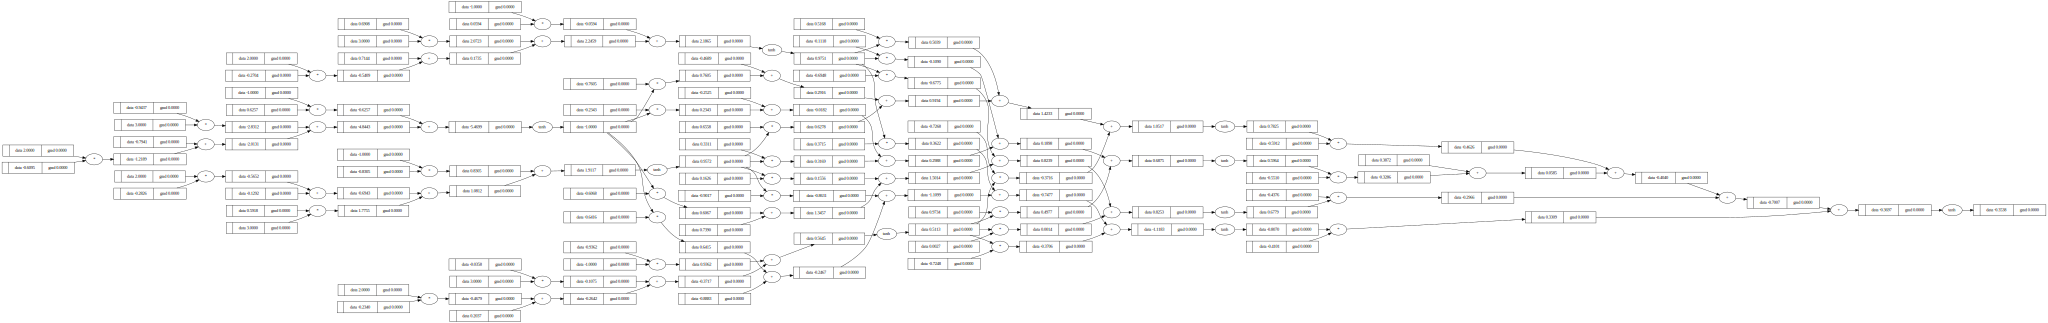

In [61]:
draw_dot(n(x))

In [83]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # labels
y_pred = [n(x) for x in xs]
y_pred

[Value(data=-0.8850656948637501),
 Value(data=0.18969640176823402),
 Value(data=-0.8743325701205671),
 Value(data=-0.7971920398757212)]

In [84]:
loss = sum([(y_out - y_gt)**2 for y_gt, y_out in zip(ys, y_pred)])
loss

Value(data=8.214541733457596)

In [85]:
loss.backward()

In [86]:
n.layers[0].neurons[0].w[0].grad

2.527329273808485

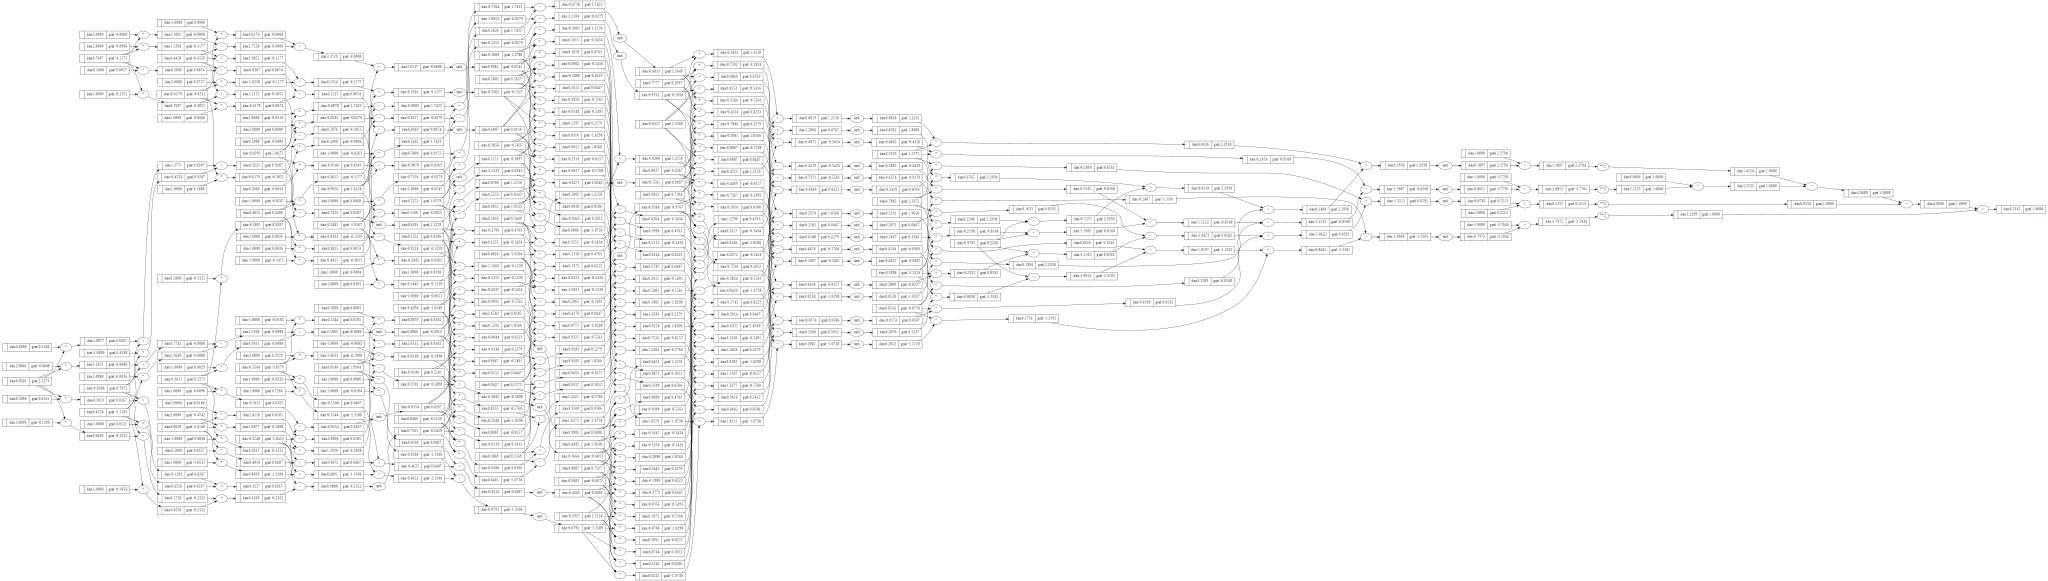

In [87]:
draw_dot(loss)

In [88]:
n.layers[0].neurons[0].w[0].data

0.6025510525518467

In [203]:
for p in n.parameters():
    p.data = p.data - 0.01 * p.grad

In [204]:
n.layers[0].neurons[0].w[0].data

-1.4146394848086818

In [205]:
y_pred = [n(x) for x in xs]
loss = sum([(y_out - y_gt)**2 for y_gt, y_out in zip(ys, y_pred)])
loss

Value(data=0.009081322453431281)

In [206]:
loss.backward()

In [207]:
y_pred

[Value(data=0.9325963880830301),
 Value(data=-0.9991918009231175),
 Value(data=-0.9991749202935375),
 Value(data=0.9326446615945855)]

In [208]:
n.parameters()

[Value(data=-1.4146394848086818),
 Value(data=0.7581580173826316),
 Value(data=-3.001957466639115),
 Value(data=-1.730314887076036),
 Value(data=0.8904607742464375),
 Value(data=-0.3725809018872279),
 Value(data=0.7526144159928212),
 Value(data=0.7040475797836312),
 Value(data=3.6700150752715737),
 Value(data=3.1994433569081524),
 Value(data=-2.055762477974839),
 Value(data=1.6806948057967042),
 Value(data=-2.4361214969650367),
 Value(data=0.8031664651436585),
 Value(data=-0.2910117473080176),
 Value(data=-1.685905757969771),
 Value(data=-0.846702451213262),
 Value(data=0.016543432214671586),
 Value(data=-0.8116973042593454),
 Value(data=1.547585679022769),
 Value(data=0.3228311325913633),
 Value(data=1.2110438008729354),
 Value(data=-0.09449333654621975),
 Value(data=0.9935637122219099),
 Value(data=-1.7459381777060878),
 Value(data=2.061262164183211),
 Value(data=3.5515274442597997),
 Value(data=-1.815171892589514),
 Value(data=-0.9661510942889626),
 Value(data=-0.7635211945809266),


In [209]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # label

In [210]:
learning_rate = 0.01

for k in range(20):

    # computing
    y_pred = [n(x) for x in xs]
    loss = sum((y_out - y_gt)**2 for y_gt, y_out in zip(ys, y_pred))

    # backpropagation
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # gradient descent
    for p in n.parameters():
        p.data = p.data - learning_rate * p.grad

    print(k, loss.data)

0 0.009081322453431281
1 0.00901534519803172
2 0.008950367153429343
3 0.008886364627900906
4 0.008823314709466132
5 0.00876119523265979
6 0.008699984747052539
7 0.008639662487410549
8 0.008580208345392623
9 0.008521602842689944
10 0.008463827105520991
11 0.0084068628404
12 0.008350692311103265
13 0.008295298316762737
14 0.008240664171020798
15 0.008186773682185587
16 0.008133611134329033
17 0.008081161269274701
18 0.00802940926942514
19 0.007978340741382511
